<a href="https://colab.research.google.com/github/jellyXuuuuu/CovidNetDeepLearning/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==1.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92.6 MB 84 kB/s 
     |████████████████████████████████| 3.2 MB 35.7 MB/s 
     |████████████████████████████████| 50 kB 3.1 MB/s 
     |████████████████████████████████| 367 kB 60.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is

In [2]:
import tensorflow as tf
print( tf.__version__ )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1


# def

In [ ]:
def read_graph_from_ckpt(ckpt_path,input_names,output_name ):   
    saver = tf.train.import_meta_graph(ckpt_path+'.meta',clear_devices=True)
    graph = tf.get_default_graph()
    with tf.Session( graph=graph) as sess:
        sess.run(tf.global_variables_initializer()) 
        saver.restore(sess,ckpt_path) 
        output_tf =graph.get_tensor_by_name(output_name) 
        pb_graph = tf.graph_util.convert_variables_to_constants( sess, graph.as_graph_def(), [output_tf.op.name]) 
     
    with tf.Graph().as_default() as g:
        tf.import_graph_def(pb_graph, name='')  
    with tf.Session(graph=g) as sess:
        OPS=get_ops_from_pb(g,input_names,output_name)
    return OPS


In [ ]:
def read_graph_from_pb(tf_model_path ,input_names,output_name):  
    with open(tf_model_path, 'rb') as f:
        serialized = f.read() 
    tf.reset_default_graph()
    gdef = tf.GraphDef()
    gdef.ParseFromString(serialized) 
    with tf.Graph().as_default() as g:
        tf.import_graph_def(gdef, name='') 
    
    with tf.Session(graph=g) as sess: 
        OPS=get_ops_from_pb(g,input_names,output_name)
    return OPS

In [ ]:
def get_ops_from_pb(graph,input_names,output_name,save_ori_network=True):
    if save_ori_network:
        with open('ori_network.txt','w+') as w: 
            OPS=graph.get_operations()
            for op in OPS:
                txt = str([v.name for v in op.inputs])+'---->'+op.type+'--->'+str([v.name for v in op.outputs])
                w.write(txt+'\n') 
    inputs_tf = [graph.get_tensor_by_name(input_name) for input_name in input_names]
    output_tf =graph.get_tensor_by_name(output_name) 
    OPS =get_ops_from_inputs_outputs(graph, inputs_tf,[output_tf] ) 
    with open('network.txt','w+') as w: 
        for op in OPS:
            txt = str([v.name for v in op.inputs])+'---->'+op.type+'--->'+str([v.name for v in op.outputs])
            w.write(txt+'\n') 
    OPS = sort_ops(OPS)
    OPS = merge_layers(OPS)
    return OPS

# from github

In [ ]:
# util.py

def create_graph(ops):
  
  n = len(ops)
  G = [[] for i in range(n)]
  op_name_to_index = dict() 
  for i, op in enumerate(ops):
    op_name_to_index[op.name] = i 
  for i, op in enumerate(ops):
    for inp in op.inputs:
      G[op_name_to_index[inp.op.name]].append(i)

  return G 
def push_stack(stack, node, in_stack,ops):
  stack.append(node)
  if node in in_stack:
    print('cycles---->',ops[node])
    raise ValueError('Graph has cycles.')
  else:
    in_stack[node] = True

def get_unvisited_child(G, node, not_visited):
  for child in G[node]:
    if child in not_visited:
      return child
  return -1

 
#对计算节点排序，使得每个计算节点所依赖的计算节点在前面
def  sort_ops(ops):  

  G = create_graph(ops)
  n = len(ops) 
  topological_label = [-1 for i in range(n)]
  stack = []
  in_stack = dict()
  not_visited = dict.fromkeys([i for i in range(n)])
  label_counter = n-1

  while len(not_visited) > 0:
    node = list(not_visited.keys())[0]
    push_stack(stack, node, in_stack,ops)
    while len(stack) > 0:
      node = get_unvisited_child(G, stack[-1], not_visited)
      if node != -1:
        push_stack(stack, node, in_stack,ops)
      else:
        node = stack.pop()
        in_stack.pop(node)
        not_visited.pop(node)
        topological_label[node] = label_counter
        label_counter -= 1

  return [x for _, x in sorted(zip(topological_label, ops))]
 
def _get_ops_in_path(from_tensors,to_tensors,ops):
    invalid_ops=[]
    valid_ops=ops.copy()
    removed=[]
    find_invalid=True
    in_tensors = [tensor.name for tensor in from_tensors] 
    out_tensors = [tensor.name for tensor in to_tensors]
    while find_invalid:
      find_invalid=False
      for op in valid_ops:  
          for input in op.inputs:
              if input.name in out_tensors:
                out_tensors=out_tensors+[out.name for out in op.outputs]
                find_invalid=True
                break
          for output in op.outputs:
              if output.name in in_tensors:
                in_tensors=in_tensors+[input.name for input in op.inputs]
                find_invalid=True
                break
          if find_invalid:
             invalid_ops.append(op)
    
      valid_ops=[op for op in valid_ops if not op in invalid_ops]       
    print('inputs===========================')
    print([op.type for op in invalid_ops if 'Con' in op.name])
    print('end inputs========================')
    print(out_tensors)
    return valid_ops

In [ ]:
# nodeObj.py

class OPNode:
    def __init__(self,node):
        if not node is None:
            self.node=node 
            self.type=node.type
            self.inputs=node.inputs
            self.outputs=node.outputs
            self.name = node.name 
    @classmethod
    def my_init(cls,type,inputs,outputs,name):
        thiz = cls(None)
        thiz.node=None
        thiz.type= type
        thiz.inputs= inputs
        thiz.outputs= outputs
        thiz.name = name 
        return thiz
    def __eq__(self,obj):
        if obj is None:
            return False
        if obj.name:
            return self.name== obj.name
        return False
    def __hash__(self):
        return self.node.__hash__()
class TSNode:
    def __init__(self,node,op_node):
        self.node=node  
        self.op=op_node 
        self.dtype=node.dtype
        self.name = node.name 
        self.shape=node.shape 
        self.get_shape=node.get_shape
        self.next_ops=node.consumers()
   
    def consumers(self):
        return self.next_ops      
    def eval(self):
        return self.node.eval()
    def __eq__(self,obj):
        if obj is None:
            return False
        if obj.name:
            return self.name== obj.name
        return False
    def __hash__(self):
        return self.node.__hash__()

In [ ]:
# graph_builder.py

# from NodeObj import OPNode,TSNode
class GNode:
    def __init__(self,id,node):
        self.node=node
        self.name=node.name
        self.id=id
        self.pre_ids=None
        self.next_ids=None
        if isinstance(node,OPNode):
            self.type=node.type
            self.pre=node.inputs
            self.next=node.outputs
        else:
            self.pre=[node.op]
            self.next=node.consumers()
            self.shape=node.shape
    
    def __str__(self):
        if isinstance(self.node,OPNode):
            return 'op☯'+str(self.id)+'☯'+self.type+'☯'+self.name+'☯'\
                   +' '.join([str(id) for id in self.pre_ids])+'☯'\
                   +' '.join([str(id) for id in self.next_ids])
        else:
             
            return 'ts☯'+str(self.id)+'☯'+str(self.shape)+'☯'+self.name+'☯'\
                   +' '.join([str(id) for id in self.pre_ids])+'☯'\
                   +' '.join([str(id) for id in self.next_ids])
class GraphBuilder:
    def __init__(self,file_dst):
        self.file_dst=file_dst  
        self.layers=[]
        self.nodes_in_layers=set()
        self.node_map=dict()
        self.id=0
    def __next_id(self):
        self.id=self.id+1
        return self.id 
    def __add_node_at(self,g_node,layer_idx):
       
        max_layer=len(self.layers)
        if layer_idx>=max_layer:
            self.layers.append([g_node])
        else:
            nodes=self.layers[layer_idx]
            nodes.append(g_node) 
        self.nodes_in_layers.add(g_node.name)
    def __to_gnode(self,nodes):
        gnodes=[]
        for node in nodes:
            g_node=self.node_map.get(node.name,None)
            if g_node is None:
                id=self.__next_id()
                g_node=GNode(id,node)
                self.node_map[node.name]=g_node
            gnodes.append(g_node)
        return gnodes
    def __max_ts_idx(self,ts_list):
        max_idx=-1
        for ts in ts_list:
            for idx,nodes in enumerate(self.layers):
                if ts in nodes and (idx>max_idx):
                    max_idx=idx
        return max_idx
    def __mv_node_to_layer(self,gnode,layer_idx):
        for idx,nodes in enumerate(self.layers):
            if gnode in nodes:
                if not idx==layer_idx:
                   nodes.remove(gnode)
                   self.layers[layer_idx].append(gnode)
                break
    def __print_layers(self):
        for idx,layer in enumerate(self.layers):
            dnames=[]
            for node in layer:
                dnames.append(node.name.split('/')[-1])
            print('layer-->',idx,','.join(dnames))          
    def add_op(self,op_node):
         
        inputs = self.__to_gnode(op_node.inputs)
        op_gnode = self.__to_gnode([op_node])[0]
        outputs = self.__to_gnode(op_node.outputs)
        max_idx=self.__max_ts_idx(inputs)
        # print('max_idx-->',max_idx)
        
        if max_idx<0:
            for input in inputs:
                self.__add_node_at(input,0)
            self.__add_node_at(op_gnode,1)
            op_idx=1
        else:
            op_idx=max_idx+1
            self.__add_node_at(op_gnode,max_idx+1)
            for input in inputs: 
                if input.name in self.nodes_in_layers:#已经添加过
                    continue
                else:
                    self.__add_node_at(input,max_idx)
                     
        if len(outputs)>0:
            output=outputs[0]
            if not output.name in self.nodes_in_layers:#未添加 
                self.__add_node_at(output,op_idx+1)
                
        # print('==============================',len(outputs))
        # self.__print_layers()
    def __layers_to_str(self):
        str_layers=[]
        for layer in self.layers: 
            layer = [str(l) for l in layer]
            str_layers.append('&'.join(layer))
        return '卍'.join(str_layers)
    def __set_ids(self):
        for layer in self.layers:
            for node in layer:
                node.pre_ids=[]
                node.next_ids=[]
                for pre in node.pre:
                    gnode = self.node_map.get(pre.name,None)
                    if not gnode is None:
                        node.pre_ids.append(gnode.id)
                for next in node.next:
                    gnode = self.node_map.get(next.name,None)
                    if not gnode is None:
                        node.next_ids.append(gnode.id)
    def build(self):  
        # self.__print_layers()
        with open('html/show_graph.html','r',encoding='utf-8') as r:
            tmp_html=r.read()
        with open('html/NodeObj.js','r',encoding='utf-8') as r:
            js1=r.read()
        with open('html/ShowGraph.js','r',encoding='utf-8') as r:
            js2=r.read()
        self.__set_ids()
        data=self.__layers_to_str()
        data = '<script type="text/javascript">data="'+data+'";</script>'
        with open(self.file_dst,'w+',encoding='utf-8') as w:
            w.write(data+'\n'+tmp_html)
            w.write( '\n<script type="text/javascript">'+js1+'</script>')
            w.write( '\n<script type="text/javascript">'+js2+'</script>') 

In [ ]:
# merge_layers.py

# from NodeObj import OPNode 
def get_dropout_op_from(ops,start_dropout_op): 
    op_queue=[start_dropout_op]
    do_ops=set() 
    while len(op_queue)>0:
        op = op_queue.pop(0) 
        for inp in op.inputs:
            if (inp.op in ops) and ('dropout' in inp.op.name) and (not inp.op in do_ops):
                op_queue.append(inp.op) 
        for output in op.outputs:
            for next_op in output.consumers(): 
                if (next_op in ops) and ('dropout' in next_op.name) and (not next_op in do_ops): 
                    op_queue.append(next_op)
        do_ops.add(op) 
    return   do_ops  

def merge_dropout_ops(sorted_ops,dropout_ops):
    dropout_idx=0
    merged_dropout=[]
    dp_input_ops=[] 
    for dropout in dropout_ops:
        dropout_input_tensor=set()
        dropout_output_tensor=set()
        input_op  = set()
        output_op= set()
        keep_prob=None 
        for dp in dropout:
            if 'keep_prob' in dp.name:
                keep_prob=dp
            for input in  dp.inputs:
                if input.op in sorted_ops and (not input.op in dropout):
                    dropout_input_tensor.add(input)
                    input_op.add(dp)
            for output in dp.outputs:
                for op in output.consumers():
                    if op in sorted_ops and (not op in dropout):
                        dropout_output_tensor.add(output)  
                        output_op.add(dp)
        name = 'Merged_dropout:'+str(dropout_idx)+'_'+str(keep_prob.outputs[0].eval())
        dp_op = OPNode.my_init('Dropout',list(dropout_input_tensor),list(dropout_output_tensor) , name)  
        for inp in dropout_input_tensor:
            consumer=set()
            for c_op in inp.consumers():
                if c_op.name in [op.name for op in input_op]:
                   consumer.add(dp_op)
                else:
                    consumer.add(c_op)
        for output in dropout_output_tensor:
            output.op=dp_op
        dropout_idx=dropout_idx+1  
        merged_dropout.append(dp_op)
        dp_input_ops.append(input_op) 
    return merged_dropout,dp_input_ops
def get_dropout_op_index(dp_op,dp_input_ops):
    for idx,dp_set in enumerate(dp_input_ops):
        if dp_op in dp_set:
            return idx
    return -1
def merge_dropout(sorted_ops):
    visited_op_name=set()
    dropout_ops = []
    for op in sorted_ops:
        if op.name in visited_op_name: 
            continue
        if 'dropout' in op.name:
            do_ops = get_dropout_op_from(sorted_ops,op)
            for v_op in do_ops:
                visited_op_name.add(v_op.name)
            dropout_ops.append( do_ops )
    merged_dp_ops,dp_input_ops = merge_dropout_ops(sorted_ops,dropout_ops)
    new_sorted_ops=[]
    visited_dropout_idx=set()
    for op in sorted_ops:
        if 'dropout' in op.name:
            idx = get_dropout_op_index(op, dp_input_ops)
            if idx>=0 and (not idx in visited_dropout_idx):
                dp_op = merged_dp_ops[idx]
                new_sorted_ops.append(dp_op)
                visited_dropout_idx.add(idx)
        else:
            new_sorted_ops.append(op)
    return new_sorted_ops
def merge_identity_const(sorted_ops):
    new_sorted_ops=[]
    for op in sorted_ops:
        if op.type=='Const':#忽略Const
            continue
        if op.type=='Identity':#去掉Identity  
            op.outputs[0].name=op.inputs[0].name 
            continue 
        new_sorted_ops.append(op)
    return new_sorted_ops
def get_squeeze_end_op(sorted_ops,start_squeeze_op):
    ops_in_path=set()
    end_op=None 
    flag=False
    for op in sorted_ops:
        if op == start_squeeze_op:
            flag=True
        if flag:
            ops_in_path.add(op)
            if op.type=='Reshape':
                end_op=op
                break 
    visited_ops=set() 
    if not end_op is None:
        ops_in_path.remove(start_squeeze_op)
        op_queue=list(ops_in_path)
       
        while len(op_queue)>0:
            op =op_queue.pop(0) 
            for inp in op.inputs:
                if inp.op !=start_squeeze_op and (not inp.op in visited_ops):
                    op_queue.append(inp.op)
            visited_ops.add(op)
    print(len(ops_in_path))
    return end_op,visited_ops
def merge_squeeze(sorted_ops):
    new_sorted_ops=[]
    need_remove_ops=set()
    for op in sorted_ops:
        if op.type=='Squeeze':
           end_op,need_removed = get_squeeze_end_op(sorted_ops,op)
           if not end_op is None: 
               ts = end_op.outputs[0]
               ts.op=op
               op.outputs=[ts]
               need_remove_ops|=need_removed
        new_sorted_ops.append(op) 
    new_sorted_ops=[op for op in new_sorted_ops if not op in need_remove_ops]
    return new_sorted_ops
def merge_layers(sorted_ops):
    sorted_ops = merge_dropout(sorted_ops)
    sorted_ops = merge_identity_const(sorted_ops)
    sorted_ops = merge_squeeze(sorted_ops)
    return sorted_ops

In [ ]:
# read_graph.py

import tensorflow as tf
import os
import sys
# from utils import sort_ops ,_get_ops_in_path
# from GraphBuilder import GraphBuilder
# from MergeLayers import merge_layers
# from NodeObj import OPNode,TSNode
def remove_identity_const(sorted_ops):
    ops=[]
    for op in sorted_ops:
        if op.type=='Const':
            continue
        elif op.type=='Identity':
            output = op.outputs[0]
            output.identity_from=op.inputs[0]
            sorted_ops.remove(op)
            # print('--->',output.identity_from)
        else:
            continue

    return sorted_ops
def read_graph_from_pb(tf_model_path ,input_names,output_name):  
    with open(tf_model_path, 'rb') as f:
        serialized = f.read() 
    tf.reset_default_graph()
    gdef = tf.GraphDef()
    gdef.ParseFromString(serialized) 
    with tf.Graph().as_default() as g:
        tf.import_graph_def(gdef, name='') 
    
    with tf.Session(graph=g) as sess: 
        OPS=get_ops_from_pb(g,input_names,output_name)
    return OPS
 
def remove_ops_before_inputs(inputs,ops):
    tensor_queue=inputs.copy()  
    visited_ts=set()
    invalid_ops=set()
    while len(tensor_queue)>0:
        ts = tensor_queue.pop(0) 
        if not ts.op in invalid_ops: 
            invalid_ops.add(ts.op)
            tensor_queue=tensor_queue+[inp for inp in  ts.op.inputs if not inp in visited_ts]  
        visited_ts.add(ts) 
    ops = [op for op in ops if not op in invalid_ops]
    ops = get_connected_ops(ops,inputs) 
    return ops
def get_connected_ops(ops_set,start_tensors):
    visited_ts = set()
    visited_ops=set()
    ts_queue=start_tensors 
    while len(ts_queue)>0:
        ts = ts_queue.pop(0) 
        if ts.op in ops_set:
            visited_ops.add(ts.op)
            ts_queue=ts_queue+[input for input in ts.op.inputs if not input in visited_ts]
        for op in ts.consumers():
            if op in ops_set:
                visited_ops.add(op) 
                ts_queue=ts_queue+[output for output in op.outputs if not output in visited_ts]
        visited_ts.add(ts)
    ops = [op for op in ops_set if op in visited_ops] 
    return ops
 
def ops_to_OPNodes(ops,inputs):

    ops_map = dict()
    ts_set=set()
    ts_map=dict()
   
    for op in ops:
        op_node = OPNode(op)
        ops_map[op]= op_node
        ts_set |=set([ts for ts in op.inputs])
        ts_set |=set([ts for ts in op.outputs])
    for ts in ts_set:
        ts_map[ts]=TSNode(ts,None) 
    for op,op_node in ops_map.items(): 
        inps=[]
        for inp in op.inputs:#修改节点输入
            inp = ts_map[inp]
            inps.append(inp)
        op_node.inputs=inps
        outputs=[]
        for output in op.outputs:#修改节点输出
            output = ts_map[output]
            outputs.append(output)
        op_node.outputs=outputs
    for ts,ts_node in ts_map.items():
        consumers=[] 
        for op in ts.consumers():
            if op in ops:
                consumers.append(ops_map[op]) 
        ts_node.next_ops=consumers 
        ts_node.op = ops_map.get(ts.op,None)
        if ts_node.op==None:
            print('---->',ts_node.name)
    print(inputs)
    #将inputs用placeholder替换
    replace_input=dict() 
    for input in inputs:#将input映射placeholder 
        # if not input.op.type=='Placeholder':
        input_shape = input.get_shape()
        if input_shape==None:
            input_shape=[None,None,None,None]
        ph = tf.placeholder(input.dtype,input_shape)
        print(ph.get_shape())
        replace_input[input.name] = ph
        ph_node = OPNode(ph.op) 
        ops_map[ph.op]=ph_node
   
    for op,op_node in ops_map.items():
        new_inputs=[] 
        for input in op_node.inputs:
            input = replace_input.get(input.name,input) #placeholder output
            new_inputs.append(input) 
        op_node.inputs=new_inputs 
        
    return ops_map.values() 

def get_ops_from_inputs_outputs(graph, inputs,outputs):
    ops = graph.get_operations() 
    ops=remove_ops_before_inputs(inputs.copy(),ops)
    ops = ops_to_OPNodes(ops,inputs)
    return ops
def get_ops_from_pb(graph,input_names,output_name,save_ori_network=True):
    if save_ori_network:
        with open('ori_network.txt','w+') as w: 
            OPS=graph.get_operations()
            for op in OPS:
                txt = str([v.name for v in op.inputs])+'---->'+op.type+'--->'+str([v.name for v in op.outputs])
                w.write(txt+'\n') 
    inputs_tf = [graph.get_tensor_by_name(input_name) for input_name in input_names]
    output_tf =graph.get_tensor_by_name(output_name) 
    OPS =get_ops_from_inputs_outputs(graph, inputs_tf,[output_tf] ) 
    with open('network.txt','w+') as w: 
        for op in OPS:
            txt = str([v.name for v in op.inputs])+'---->'+op.type+'--->'+str([v.name for v in op.outputs])
            w.write(txt+'\n') 
    OPS = sort_ops(OPS)
    OPS = merge_layers(OPS)
    return OPS
def read_graph_from_ckpt(ckpt_path,input_names,output_name ):   
    saver = tf.train.import_meta_graph(ckpt_path+'.meta',clear_devices=True)
    graph = tf.get_default_graph()
    with tf.Session( graph=graph) as sess:
        sess.run(tf.global_variables_initializer()) 
        saver.restore(sess,ckpt_path) 
        output_tf =graph.get_tensor_by_name(output_name) 
        pb_graph = tf.graph_util.convert_variables_to_constants( sess, graph.as_graph_def(), [output_tf.op.name]) 
     
    with tf.Graph().as_default() as g:
        tf.import_graph_def(pb_graph, name='')  
    with tf.Session(graph=g) as sess:
        OPS=get_ops_from_pb(g,input_names,output_name)
    return OPS

def gen_graph(ops,html_dst):
    gb = GraphBuilder(html_dst) 
    for op in ops:
        if not len(op.outputs)>0:
            continue  
        if(op.type=='Placeholder'):
            continue
        gb.add_op(op )
    gb.build()
def print_graph(ops):
    
    for op in ops:
        output = op.outputs[0] 
        print(op.inputs,output)
def read_graph(model_path,input_names,output_name,html_dst):
    dir_path = os.path.dirname(html_dst)
    if len(dir_path)>0 and not os.path.exists(dir_path):
        os.makedirs(dir_path)
    if model_path.endswith('pb'):
        ops = read_graph_from_pb( model_path ,input_names,output_name)	
    else:
        ops = read_graph_from_ckpt(model_path ,input_names,output_name)
    
    print(dir_path)
    gen_graph(ops,html_dst)
# if __name__=='__main__':
#     model_path = sys.argv[1]
#     input_names = sys.argv[2]
#     output_name = sys.argv[3]
#     html_dst = sys.argv[4]
#     input_names=input_names.split(',')
#     read_graph(model_path,input_names,output_name,html_dst)
  
# read_graph('../../mobilenet_v1_1.0_192.ckpt',['batch:0'],'MobilenetV1/Predictions/Reshape_1:0','output/html_dst3.html')
# read_graph( '../../mobilenet_v1_1.0_192_frozen.pb' ,['input:0'],'MobilenetV1/Predictions/Reshape_1:0','output/html_dst1.html')


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

# load files

In [3]:
!cp -r 'drive/MyDrive/covid/models/' .

In [4]:
!cp -r 'drive/MyDrive/covid/labels/' .

In [2]:
!cp -r 'drive/MyDrive/covid/assets/' .

# operation

In [ ]:
input_names = ['input_1:0']

In [ ]:
ops = read_graph_from_ckpt("models/COVIDNet-CXR-2/model", input_names, 'norm_dense_2/Softmax:0')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


----> input_1:0
[<tf.Tensor 'input_1:0' shape=(?, 480, 480, 3) dtype=float32>]
(?, 480, 480, 3)


In [ ]:
ops


# -> pytorch

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 6.9 MB/s 
     |████████████████████████████████| 7.6 MB 45.0 MB/s 
     |████████████████████████████████| 182 kB 63.3 MB/s 
ERROR: Operation cancelled by user


### albert model

In [ ]:
import argparse
import logging
import torch
from transformers import AlbertConfig, AlbertForPreTraining, load_tf_weights_in_albert

logging.basicConfig(level=logging.INFO)


def convert_tf_checkpoint_to_pytorch(tf_checkpoint_path, albert_config_file, pytorch_dump_path):
    # 初始化 PyTorch 模型
    config = AlbertConfig.from_json_file(albert_config_file)
    print("Building PyTorch model from configuration: {}".format(str(config)))
    model = AlbertForPreTraining(config)

    # 从 tf 的 checkpoint 文件中加载模型权重
    load_tf_weights_in_albert(model, config, tf_checkpoint_path)

    # 保存 PyTorch 模型
    print("Save PyTorch model to {}".format(pytorch_dump_path))
    torch.save(model.state_dict(), pytorch_dump_path)




In [ ]:
# if __name__ == "__main__":

# https://github.com/delldu/Albert

parser = argparse.ArgumentParser()
# 参数设置
parser.add_argument("--tf_checkpoint_path", default='./resources/albert_base_zh/model.ckpt-best', type=str,
                    required=False, help="Path to the TensorFlow checkpoint path.")
parser.add_argument("--albert_config_file", default='./resources/albert_base_zh/albert_config.json', type=str,
                    required=False,
                    help="The config json file corresponding to the pre-trained ALBERT model. \n""This specifies the model architecture.", )
parser.add_argument("--pytorch_dump_path", default='./resources/albert_base_zh/pytorch_model.bin', type=str, required=False,
                    help="Path to the output PyTorch model.")

args = parser.parse_args(args = [])
args.tf_checkpoint_path = "models/COVIDNet-CXR-2/model"
args.albert_config_file = "albert_config.json"
args.pytorch_dump_path = "pytorch_model.bin"


convert_tf_checkpoint_to_pytorch(args.tf_checkpoint_path, args.albert_config_file, args.pytorch_dump_path)

FileNotFoundError: ignored

## get graph

In [ ]:
import tensorflow as tf
print( tf.__version__ )

In [ ]:
''' //////////////////////////////////////////////////// '''
# definitions

# data.py
import tensorflow as tf
from tensorflow import keras

from functools import partial
import numpy as np
import os
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]

def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv2.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv2.resize(img, (size, size))
    return img

def process_image_file_medusa(filepath, size):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    img = img.astype('float64')
    img -= img.mean()
    img /= img.std()
    return np.expand_dims(img, -1)

def random_ratio_resize(img, prob=0.3, delta=0.1):
    if np.random.rand() >= prob:
        return img
    ratio = img.shape[0] / img.shape[1]
    ratio = np.random.uniform(max(ratio - delta, 0.01), ratio + delta)

    if ratio * img.shape[1] <= img.shape[1]:
        size = (int(img.shape[1] * ratio), img.shape[1])
    else:
        size = (img.shape[0], int(img.shape[0] / ratio))

    dh = img.shape[0] - size[1]
    top, bot = dh // 2, dh - dh // 2
    dw = img.shape[1] - size[0]
    left, right = dw // 2, dw - dw // 2

    if size[0] > 480 or size[1] > 480:
        print(img.shape, size, ratio)

    img = cv2.resize(img, size)
    img = cv2.copyMakeBorder(img, top, bot, left, right, cv2.BORDER_CONSTANT,
                             (0, 0, 0))

    if img.shape[0] != 480 or img.shape[1] != 480:
        raise ValueError(img.shape, size)
    return img

_augmentation_transform = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.9, 1.1),
    zoom_range=(0.85, 1.15),
    fill_mode='constant',
    cval=0.,
)

def apply_augmentation(img):
    img = random_ratio_resize(img)
    img = _augmentation_transform.random_transform(img)
    return img

def _process_csv_file(file):
    with open(file, 'r') as fr:
        files = fr.readlines()
    return files


class BalanceCovidDataset(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(
            self,
            data_dir,
            csv_file,
            is_training=True,
            batch_size=8,
            medusa_input_shape=(256, 256),
            input_shape=(480, 480),
            n_classes=2,
            num_channels=3,
            mapping={
                'negative': 0,
                'positive': 1,
            },
            shuffle=True,
            augmentation=apply_augmentation,
            covid_percent=0.5,
            class_weights=[1., 1.],
            top_percent=0.08,
            is_severity_model=False,
            is_medusa_backbone=False,
    ):
        'Initialization'
        self.datadir = data_dir
        self.dataset = _process_csv_file(csv_file)
        self.is_training = is_training
        self.batch_size = batch_size
        self.N = len(self.dataset)
        self.medusa_input_shape = medusa_input_shape
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.num_channels = num_channels
        self.mapping = mapping
        self.shuffle = shuffle
        self.covid_percent = covid_percent
        self.class_weights = class_weights
        self.n = 0
        self.augmentation = augmentation
        self.top_percent = top_percent
        self.is_severity_model = is_severity_model
        self.is_medusa_backbone = is_medusa_backbone

        # If using MEDUSA backbone load images without crop
        if self.is_medusa_backbone:
            self.load_image = partial(process_image_file, top_percent=0, crop=False)
        else:
            self.load_image = process_image_file

        datasets = {}
        for key in self.mapping.keys():
            datasets[key] = []

        for l in self.dataset:
            datasets[l.split()[2]].append(l)
        
        if self.is_severity_model:
            self.datasets = [
                datasets['level2'], datasets['level1']
            ]
        elif self.n_classes == 2:
            self.datasets = [
                datasets['negative'], datasets['positive']
            ]
        elif self.n_classes == 3:
            self.datasets = [
                datasets['normal'] + datasets['pneumonia'],
                datasets['COVID-19'],
            ]
        else:
            raise Exception('Only binary or 3 class classification currently supported.')
        print(len(self.datasets[0]), len(self.datasets[1]))

        self.on_epoch_end()

    def __next__(self):
        # Get one batch of data
        model_inputs = self.__getitem__(self.n)
        # Batch index
        self.n += 1

        # If we have processed the entire dataset then
        if self.n >= self.__len__():
            self.on_epoch_end()
            self.n = 0

        return model_inputs

    def __len__(self):
        return int(np.ceil(len(self.datasets[0]) / float(self.batch_size)))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            for v in self.datasets:
                np.random.shuffle(v)

    def __getitem__(self, idx):
        batch_x = np.zeros((self.batch_size, *self.input_shape, self.num_channels))
        batch_y = np.zeros(self.batch_size)

        if self.is_medusa_backbone:
            batch_sem_x = np.zeros((self.batch_size, *self.medusa_input_shape, 1))

        batch_files = self.datasets[0][idx * self.batch_size:(idx + 1) * self.batch_size]

        # upsample covid cases
        covid_size = max(int(len(batch_files) * self.covid_percent), 1)
        covid_inds = np.random.choice(np.arange(len(batch_files)),
                                      size=covid_size,
                                      replace=False)
        covid_files = np.random.choice(self.datasets[1],
                                       size=covid_size,
                                       replace=False)
        for i in range(covid_size):
            batch_files[covid_inds[i]] = covid_files[i]

        for i in range(len(batch_files)):
            sample = batch_files[i].split()

            if self.is_training:
                folder = 'train'
            else:
                folder = 'test'

            image_file = os.path.join(self.datadir, folder, sample[1])
            x = self.load_image(
                image_file,
                self.input_shape[0],
                top_percent=self.top_percent,
            )

            if self.is_training and hasattr(self, 'augmentation'):
                x = self.augmentation(x)

            x = x.astype('float32') / 255.0

            if self.is_medusa_backbone:
                sem_x = process_image_file_medusa(image_file, self.medusa_input_shape[0])
                batch_sem_x[i] = sem_x
            
            y = self.mapping[sample[2]]

            batch_x[i] = x
            batch_y[i] = y

        class_weights = self.class_weights
        weights = np.take(class_weights, batch_y.astype('int64'))
        batch_y = keras.utils.to_categorical(batch_y, num_classes=self.n_classes)

        if self.is_medusa_backbone:
            return batch_sem_x, batch_x, batch_y, weights, self.is_training
        else:
            return batch_x, batch_y, weights, self.is_training

''' \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\ '''        


from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
import os, argparse

# To remove TF Warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# if __name__ == '__main__':
    # args = []
'''
python inference.py \
--weightspath models/COVIDNet-CXR-2 \
--metaname model.meta \
--ckptname model \
--n_classes 2 \
--imagepath assets/ex-covid.jpeg \
--in_tensorname input_1:0 \
--out_tensorname norm_dense_2/Softmax:0

python inference.py \
--weightspath models/COVIDNet-CXR-3 \
--metaname model.meta \
--ckptname model \
--n_classes 2 \
--imagepath assets/ex-covid.jpeg \
--out_tensorname softmax/Softmax:0 \
--is_medusa_backbone

'''

# USE COVIDNet CXR 2

args_weightspath = 'models/COVIDNet-CXR-2' 
args_metaname = 'model.meta'
args_ckptname = 'model'
args_n_classes = 2

args_testfolder = 'data/test'
args_trainfile = 'labels/train_COVIDx9B.txt'
args_testfile = 'labels/test_COVIDx9B.txt'

args_out_tensorname = 'norm_dense_2/Softmax:0'
args_logit_tensorname = 'norm_dense_2/MatMul:0'
args_is_severity_model = False
args_is_medusa_backbone = False

args_in_tensorname = 'input_1:0'
args_in_tensorname_medusa = 'input_1:0'
args_input_size = 480
args_input_size_medusa = 256
args_top_percent = 0.08

'''
<<<<<<<<<<<<<<<<<<Here to change the test image!!! >>>>>>>>>>>>>>>>>>>>
'''

args_imagepath = 'assets/ex-covid.jpeg'
# args_imagepath = "data/test/0a8d486f-1aa6-4fcf-b7be-4bf04fc8628b.png"
# args_imagepath = "drive/MyDrive/covid/ricord_images/MIDRC-RICORD-1C-SITE2-000293-40361-0.png"

sess = tf.compat.v1.Session()
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)



if args_is_severity_model:
    # For COVIDNet CXR-S training with COVIDxSev level 1 and level 2 air space seveirty grading
    mapping = {'level2': 0, 'level1': 1}
    inv_mapping = {0: 'level2', 1: 'level1'}
elif args_n_classes == 2:
    # For COVID-19 positive/negative detection
    mapping = {'negative': 0, 'positive': 1}
    inv_mapping = {0: 'negative', 1: 'positive'}
elif args_n_classes == 3:
    # For detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia
    mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
    inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}
else:
    raise Exception('''COVID-Net currently only supports 2 class COVID-19 positive/negative detection
        or 3 class detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia''')

print("mapping", mapping)
mapping_keys = list(mapping.keys())

# tf.get_default_graph()
# tf.compat.v1.get_default_graph()
# saver = tf.compat.v1.train.import_meta_graph(os.path.join(args_weightspath, args_metaname))
# saver.restore(sess, os.path.join(args_weightspath, args_ckptname))

# graph = tf.get_default_graph()

# image_tensor = graph.get_tensor_by_name(args_in_tensorname)
# pred_tensor = graph.get_tensor_by_name(args_out_tensorname)

sess = tf.Session()
tf.get_default_graph()
saver = tf.train.import_meta_graph(os.path.join(args_weightspath, args_metaname))
saver.restore(sess, os.path.join(args_weightspath, args_ckptname))

graph = tf.get_default_graph()

# image_tensor = graph.get_tensor_by_name(args_in_tensorname)
# pred_tensor = graph.get_tensor_by_name(args_out_tensorname)

# if args_is_medusa_backbone:
#     x = process_image_file(args_imagepath, args_input_size, top_percent=0, crop=False)
#     x = x.astype('float32') / 255.0
#     medusa_image_tensor = graph.get_tensor_by_name(args_in_tensorname_medusa)
#     medusa_x = process_image_file_medusa(args_imagepath, args_input_size_medusa)
#     feed_dict = {
#                 medusa_image_tensor: np.expand_dims(medusa_x, axis=0),
#                 image_tensor: np.expand_dims(x, axis=0),
#             } 
# else:
#     x = process_image_file(args_imagepath, args_input_size, top_percent=args_top_percent)
#     x = x.astype('float32') / 255.0
#     feed_dict = {image_tensor: np.expand_dims(x, axis=0)}

# print("feed_dict", feed_dict)

# pred = sess.run(pred_tensor, feed_dict=feed_dict)

# # print("pred", pred)

# # print('Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
# # print('Confidence')
# # print(' '.join('{}: {:.3f}'.format(cls.capitalize(), pred[0][i]) for cls, i in mapping.items()))
# # print('**DISCLAIMER**')
# # print('Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.')



In [ ]:
print(graph)

## test

### prnet_full.py

In [ ]:
# prnet_full.py  - https://github.com/liguohao96/pytorch-prnet/blob/7475fa1c593977a9989fd80bec7ead686f075811/prnet_full.py#L123
from torch import nn

def padding_same_conv2d(input_size, in_c, out_c, kernel_size=4, stride=1):
    output_size = input_size // stride
    padding_num = stride * (output_size - 1) - input_size + kernel_size
    if padding_num % 2 == 0:
        return nn.Sequential(nn.Conv2d(in_c, out_c, kernel_size=kernel_size, stride=stride, padding=padding_num // 2, bias=False))
    else:
        return nn.Sequential(
            nn.ConstantPad2d((padding_num // 2, padding_num // 2 + 1, padding_num // 2, padding_num // 2 + 1), 0),
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, stride=stride, padding=0, bias=False)
        )

# import threading
class resBlock(nn.Module):
    instance_num = 0
    # instance_num_lock = threading.Lock()
    def __init__(self, in_c, out_c, kernel_size=4, stride=1, input_size=None):
        super().__init__()
        self.instance_idx = self.__class__.instance_num
        self.__class__.instance_num += 1
        assert kernel_size == 4
        self.shortcut = lambda x: x
        self.tf_map = {}
        if in_c != out_c:
            self.shortcut = nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, bias=False)
            self.tf_map['{}/shortcut/weights'.format(self.instance_name())] = 'shortcut.weight'

        main_layers = [
            nn.Conv2d(in_c, out_c // 2, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_c // 2, eps=0.001, momentum=0.001),
            nn.ReLU(inplace=True),
        ]
        self.tf_map['{}/Conv/weights'.format(self.instance_name())] = 'main.0.weight'
        self.tf_map['{}/Conv/BatchNorm/gamma'.format(self.instance_name())] = 'main.1.weight'
        self.tf_map['{}/Conv/BatchNorm/beta'.format(self.instance_name())] = 'main.1.bias'
        self.tf_map['{}/Conv/BatchNorm/moving_mean'.format(self.instance_name())] = 'main.1.running_mean'
        self.tf_map['{}/Conv/BatchNorm/moving_variance'.format(self.instance_name())] = 'main.1.running_var'

        main_layers.extend([
            *padding_same_conv2d(input_size, out_c // 2, out_c // 2, kernel_size=kernel_size, stride=stride),
            nn.BatchNorm2d(out_c // 2, eps=0.001, momentum=0.001),
            nn.ReLU(inplace=True)])
        conv_idx = len(main_layers) - 3
        self.tf_map['{}/Conv_1/weights'.format(self.instance_name())] = 'main.{}.weight'.format(conv_idx)
        self.tf_map['{}/Conv_1/BatchNorm/gamma'.format(self.instance_name())] = 'main.{}.weight'.format(conv_idx+1)
        self.tf_map['{}/Conv_1/BatchNorm/beta'.format(self.instance_name())] = 'main.{}.bias'.format(conv_idx+1)
        self.tf_map['{}/Conv_1/BatchNorm/moving_mean'.format(self.instance_name())] = 'main.{}.running_mean'.format(conv_idx+1)
        self.tf_map['{}/Conv_1/BatchNorm/moving_variance'.format(self.instance_name())] = 'main.{}.running_var'.format(conv_idx+1)

        main_layers.extend(
            padding_same_conv2d(input_size, out_c // 2, out_c, kernel_size=1, stride=1)
        )
        conv_idx = len(main_layers) - 1
        self.tf_map['{}/Conv_2/weights'.format(self.instance_name())] = 'main.{}.weight'.format(conv_idx)
        self.main = nn.Sequential(*main_layers)
        self.activate = nn.Sequential(
            nn.BatchNorm2d(out_c, eps=0.001, momentum=0.001),
            nn.ReLU(inplace=True)
        )
        self.tf_map['{}/BatchNorm/gamma'.format(self.instance_name())] = 'activate.0.weight'
        self.tf_map['{}/BatchNorm/beta'.format(self.instance_name())]  = 'activate.0.bias'
        self.tf_map['{}/BatchNorm/moving_mean'.format(self.instance_name())]      = 'activate.0.running_mean'
        self.tf_map['{}/BatchNorm/moving_variance'.format(self.instance_name())]  = 'activate.0.running_var'

    def instance_name(self):
        return 'resBlock' if self.instance_idx == 0 else 'resBlock_{}'.format(self.instance_idx)

    def forward(self, x):
        shortcut_x = self.shortcut(x)
        main_x = self.main(x)
        x = self.activate(shortcut_x + main_x)
        return x


class upBlock(nn.Module):
    convtranspose_num = 0
    def __init__(self, in_c, out_c, conv_num=2):
        super().__init__()
        self.tf_map = {}
        additional_conv = []
        layer_length = 4

        self.convtrans_idx = self.__class__.convtranspose_num
        self.__class__.convtranspose_num += 1
        self.tf_map['{}/weights'.format(self.convtranspose_name())] = 'main.0.weight'
        self.tf_map['{}/BatchNorm/gamma'.format(self.convtranspose_name())] = 'main.1.weight'
        self.tf_map['{}/BatchNorm/beta'.format(self.convtranspose_name())] = 'main.1.bias'
        self.tf_map['{}/BatchNorm/moving_mean'.format(self.convtranspose_name())] = 'main.1.running_mean'
        self.tf_map['{}/BatchNorm/moving_variance'.format(self.convtranspose_name())] = 'main.1.running_var'
        for i in range(1, conv_num+1):
            self.convtrans_idx = self.__class__.convtranspose_num
            self.__class__.convtranspose_num += 1
            additional_conv += [
                nn.ConstantPad2d((2, 1, 2, 1), 0),
                nn.ConvTranspose2d(out_c, out_c, kernel_size=4, stride=1, padding=3, bias=False),
                nn.BatchNorm2d(out_c, eps=0.001, momentum=0.001),
                nn.ReLU(inplace=True)
            ]
            self.tf_map['{}/weights'.format(self.convtranspose_name())] = 'main.{}.weight'.format(i*layer_length + 0)
            self.tf_map['{}/BatchNorm/gamma'.format(self.convtranspose_name())] = 'main.{}.weight'.format(i*layer_length + 1)
            self.tf_map['{}/BatchNorm/beta'.format(self.convtranspose_name())] = 'main.{}.bias'.format(i*layer_length + 1)
            self.tf_map['{}/BatchNorm/moving_mean'.format(self.convtranspose_name())] = 'main.{}.running_mean'.format(i*layer_length + 1)
            self.tf_map['{}/BatchNorm/moving_variance'.format(self.convtranspose_name())] = 'main.{}.running_var'.format(i*layer_length + 1)

        self.main = nn.Sequential(
            # nn.ConstantPad2d((0, 1, 0, 1), 0),
            nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_c, eps=0.001, momentum=0.001),
            nn.ReLU(inplace=True),
            *additional_conv
            )

    def convtranspose_name(self):
        return 'Conv2d_transpose' if self.convtrans_idx == 0 else 'Conv2d_transpose_{}'.format(self.convtrans_idx)

    def forward(self, x):
        x = self.main(x)
        return x


class PRNet(nn.Module):
    def __init__(self, in_channel, out_channel=3):
        super().__init__()
        size = 16
        self.input_conv = nn.Sequential( #*[
            *padding_same_conv2d(256, in_channel, size, kernel_size=4, stride=1),  # 256x256x16
            nn.BatchNorm2d(size, eps=0.001, momentum=0.001),
            nn.ReLU(inplace=True)
            # ]
        ) 
        self.tf_map = {}
        conv_idx = len(self.input_conv) - 3
        self.tf_map['resfcn256/Conv/weights'] = 'input_conv.{}.weight'.format(conv_idx)
        self.tf_map['resfcn256/Conv/BatchNorm/gamma'] = 'input_conv.{}.weight'.format(conv_idx + 1)
        self.tf_map['resfcn256/Conv/BatchNorm/beta'] = 'input_conv.{}.bias'.format(conv_idx + 1)
        self.tf_map['resfcn256/Conv/BatchNorm/moving_mean'] = 'input_conv.{}.running_mean'.format(conv_idx + 1)
        self.tf_map['resfcn256/Conv/BatchNorm/moving_variance'] = 'input_conv.{}.running_var'.format(conv_idx + 1)
        self.down_conv_1 = resBlock(size, size * 2, kernel_size=4, stride=2, input_size=256)  # 128x128x32
        self.down_conv_2 = resBlock(size * 2, size * 2, kernel_size=4, stride=1, input_size=128)  # 128x128x32
        self.down_conv_3 = resBlock(size * 2, size * 4, kernel_size=4, stride=2, input_size=128)  # 64x64x64
        self.down_conv_4 = resBlock(size * 4, size * 4, kernel_size=4, stride=1, input_size=64)  # 64x64x64
        self.down_conv_5 = resBlock(size * 4, size * 8, kernel_size=4, stride=2, input_size=64)  # 32x32x128
        self.down_conv_6 = resBlock(size * 8, size * 8, kernel_size=4, stride=1, input_size=32)  # 32x32x128
        self.down_conv_7 = resBlock(size * 8, size * 16, kernel_size=4, stride=2, input_size=32)  # 16x16x256
        self.down_conv_8 = resBlock(size * 16, size * 16, kernel_size=4, stride=1, input_size=16)  # 16x16x256
        self.down_conv_9 = resBlock(size * 16, size * 32, kernel_size=4, stride=2, input_size=16)  # 8x8x512
        self.down_conv_10 = resBlock(size * 32, size * 32, kernel_size=4, stride=1, input_size=8)  # 8x8x512

        self.center_conv = nn.Sequential(
            nn.ConstantPad2d((2, 1, 2, 1), 0),
            nn.ConvTranspose2d(size * 32, size * 32, kernel_size=4, stride=1, padding=3, bias=False),  # 8x8x512
            nn.BatchNorm2d(size * 32, eps=0.001, momentum=0.001),
            nn.ReLU(inplace=True)
        )
        self.tf_map['resfcn256/Conv2d_transpose/weights'] = 'center_conv.1.weight'
        self.tf_map['resfcn256/Conv2d_transpose/BatchNorm/gamma'] = 'center_conv.2.weight'
        self.tf_map['resfcn256/Conv2d_transpose/BatchNorm/beta'] = 'center_conv.2.bias'
        self.tf_map['resfcn256/Conv2d_transpose/BatchNorm/moving_mean'] = 'center_conv.2.running_mean'
        self.tf_map['resfcn256/Conv2d_transpose/BatchNorm/moving_variance'] = 'center_conv.2.running_var'
        upBlock.convtranspose_num = 1

        self.up_conv_5 = upBlock(size * 32, size * 16)  # 16x16x256
        self.up_conv_4 = upBlock(size * 16, size * 8)  # 32x32x128
        self.up_conv_3 = upBlock(size * 8, size * 4)  # 64x64x64

        self.up_conv_2 = upBlock(size * 4, size * 2, 1)  # 128x128x32
        self.up_conv_1 = upBlock(size * 2, size, 1)  # 256x256x16

        convtranspose_idx = upBlock.convtranspose_num
        self.output_conv = nn.Sequential(
            nn.ConstantPad2d((2, 1, 2, 1), 0),
            nn.ConvTranspose2d(size, 3, kernel_size=4, stride=1, padding=3, bias=False),
            nn.BatchNorm2d(3, eps=0.001, momentum=0.001),
            nn.ReLU(inplace=True),

            nn.ConstantPad2d((2, 1, 2, 1), 0),
            nn.ConvTranspose2d(3, 3, kernel_size=4, stride=1, padding=3, bias=False),
            nn.BatchNorm2d(3, eps=0.001, momentum=0.001),
            nn.ReLU(inplace=True),

            nn.ConstantPad2d((2, 1, 2, 1), 0),
            nn.ConvTranspose2d(3, 3, kernel_size=4, stride=1, padding=3, bias=False),
            nn.BatchNorm2d(3, eps=0.001, momentum=0.001),
            nn.Sigmoid()
        )
        self.tf_map['resfcn256/Conv2d_transpose_{}/weights'.format(convtranspose_idx)] = 'output_conv.1.weight'
        self.tf_map['resfcn256/Conv2d_transpose_{}/BatchNorm/gamma'.format(convtranspose_idx)] = 'output_conv.2.weight'
        self.tf_map['resfcn256/Conv2d_transpose_{}/BatchNorm/beta'.format(convtranspose_idx)] = 'output_conv.2.bias'
        self.tf_map['resfcn256/Conv2d_transpose_{}/BatchNorm/moving_mean'.format(convtranspose_idx)] = 'output_conv.2.running_mean'
        self.tf_map['resfcn256/Conv2d_transpose_{}/BatchNorm/moving_variance'.format(convtranspose_idx)] = 'output_conv.2.running_var'

        convtranspose_idx += 1
        self.tf_map['resfcn256/Conv2d_transpose_{}/weights'.format(convtranspose_idx)] = 'output_conv.5.weight'
        self.tf_map['resfcn256/Conv2d_transpose_{}/BatchNorm/gamma'.format(convtranspose_idx)] = 'output_conv.6.weight'
        self.tf_map['resfcn256/Conv2d_transpose_{}/BatchNorm/beta'.format(convtranspose_idx)] = 'output_conv.6.bias'
        self.tf_map['resfcn256/Conv2d_transpose_{}/BatchNorm/moving_mean'.format(convtranspose_idx)] = 'output_conv.6.running_mean'
        self.tf_map['resfcn256/Conv2d_transpose_{}/BatchNorm/moving_variance'.format(convtranspose_idx)] = 'output_conv.6.running_var'

        convtranspose_idx += 1
        self.tf_map['resfcn256/Conv2d_transpose_{}/weights'.format(convtranspose_idx)] = 'output_conv.9.weight'
        self.tf_map['resfcn256/Conv2d_transpose_{}/BatchNorm/gamma'.format(convtranspose_idx)] = 'output_conv.10.weight'
        self.tf_map['resfcn256/Conv2d_transpose_{}/BatchNorm/beta'.format(convtranspose_idx)] = 'output_conv.10.bias'
        self.tf_map['resfcn256/Conv2d_transpose_{}/BatchNorm/moving_mean'.format(convtranspose_idx)] = 'output_conv.10.running_mean'
        self.tf_map['resfcn256/Conv2d_transpose_{}/BatchNorm/moving_variance'.format(convtranspose_idx)] = 'output_conv.10.running_var'
        self.collact_names()
    
    def collact_names(self):
        for name, child in self.named_children():
            if hasattr(child, 'tf_map'):
                child_map = getattr(child, 'tf_map')
                for k, v in child_map.items():
                    self.tf_map['resfcn256/{}'.format(k)] = '{}.{}'.format(name, v)

    def forward(self, x):
        x = self.input_conv(x)
        x = self.down_conv_1(x)
        x = self.down_conv_2(x)
        x = self.down_conv_3(x)
        x = self.down_conv_4(x)
        x = self.down_conv_5(x)
        x = self.down_conv_6(x)
        x = self.down_conv_7(x)
        x = self.down_conv_8(x)
        x = self.down_conv_9(x)
        x = self.down_conv_10(x)

        x = self.center_conv(x)

        x = self.up_conv_5(x)
        x = self.up_conv_4(x)
        x = self.up_conv_3(x)
        x = self.up_conv_2(x)
        x = self.up_conv_1(x)
        x = self.output_conv(x)
        return x

### tf2torch 

In [ ]:
# tf2torch - https://github.com/liguohao96/pytorch-prnet/blob/master/tf2torch.py
from collections import OrderedDict
import torch
torch_model = PRNet(3, 3)
torch_dict = OrderedDict()

for node in graph.as_graph_def().node:
    # print(node)
    if node.name in torch_model.tf_map:
        torch_name = torch_model.tf_map[node.name]
        data = graph.get_operation_by_name(node.name).outputs[0]
        data_np = sess.run(data)
        if len(data_np.shape) > 1:
            # weight layouts  |   tensorflow   |     pytorch     |  transpose   |
            # conv2d_transpose (H, W, out, in) -> (in, out, H, W)  (3, 2, 0, 1)
            # conv2d           (H, W, in, out) -> (out, in, H, W)  (3, 2, 0, 1)
            torch_dict[torch_name] = torch.tensor(np.transpose(data_np, (3, 2, 0, 1)).astype(np.float32))
        else:
            torch_dict[torch_name] = torch.tensor(data_np.astype(np.float32))
    else:
        if node.name.find('save') == -1:
            pass
            print('not in {}'.format(node.name))
torch.save(torch_dict, 'from_tf.pth')


In [ ]:
print(torch_dict)

# cam -tf

## model


In [ ]:
# model_r50 = ResNet50(weights='imagenet', include_top=False)
# model_r50.summary()
from tensorflow import keras

# Define a simple sequential model
def create_model():
  model = tf.keras.models.Sequential([
    keras.layers.Dense(512, activation=tf.keras.activations.relu, input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation=tf.keras.activations.softmax)
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])

  return model


# Create a basic model instance
model = create_model()
model.summary()

In [ ]:
import tensorflow as tf

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('models/COVIDNet-CXR-2/model.meta')
    saver.restore(sess, "models/COVIDNet-CXR-2/model")


In [ ]:
import tensorflow as tf
saver = tf.train.import_meta_graph('models/COVIDNet-CXR-2/model.meta')
sess = tf.Session()
saver.restore(sess, "models/COVIDNet-CXR-2/model")
# result = sess.run("v4:0", feed_dict={"v1:0": 12.0, "v2:0": 3.3})
# print(result)

In [ ]:
import tensorflow as tf
checkpoint_path = "models/COVIDNet-CXR-2/model.data-00000-of-00001.ckpt"
test_images = "assets/ex-covid.jpeg"
test_labels = "labels"
model.load_weights(checkpoint_path)
loss,acc = model.evaluate(test_image s,  test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

## test

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

img_m1 [[[184 184 184]
  [183 183 183]
  [183 183 183]
  ...
  [169 169 169]
  [169 169 169]
  [169 169 169]]

 [[187 187 187]
  [184 184 184]
  [181 181 181]
  ...
  [169 169 169]
  [169 169 169]
  [169 169 169]]

 [[190 190 190]
  [186 186 186]
  [183 183 183]
  ...
  [107 107 107]
  [107 107 107]
  [107 107 107]]

 ...

 [[  1   1   1]
  [  1   1   1]
  [  1   1   1]
  ...
  [  1   1   1]
  [  1   1   1]
  [  1   1   1]]

 [[  1   1   1]
  [  1   1   1]
  [  1   1   1]
  ...
  [  1   1   1]
  [  1   1   1]
  [  1   1   1]]

 [[  1   1   1]
  [  1   1   1]
  [  1   1   1]
  ...
  [  1   1   1]
  [  1   1   1]
  [  1   1   1]]]
np.expand_dims(x, axis=0) [[[[0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   ...
   [0.3764706  0.3764706  0.3764706 ]
   [0.34509805 0.34509805 0.34509805]
   [0.33333334 0.33333334 0.33333334]]

  [[0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.0039215

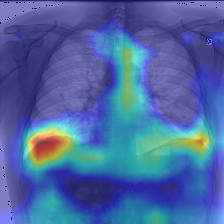

In [1]:
import cv2 as cv
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
import os, argparse

from google.colab.patches import cv2_imshow
 
def grad_cam(prob_name, label, layer_name, sess, feed_dict, nb_classes):
    """
    prob_name为softmax输出层节点名, label标签, layer_name最后一层卷积层的节点名, sess,                 
    feed_dict, nb_classes分类数
    """
 
    prob = sess.graph.get_tensor_by_name(prob_name + ':0')
    print("prob", prob)
    print("tf.one_hot([label]", tf.one_hot([label], nb_classes))
    loss = tf.multiply(prob, tf.one_hot([label], nb_classes))
    print("loss", loss)
    
    reduced_loss = tf.reduce_sum(loss[0]) # reduced_loss = tf.reduce_sum(loss, axis=1) 
    conv_output = sess.graph.get_tensor_by_name(layer_name + ':0')
    images = tf.placeholder("float", [None, 224, 224, 3])
    print("reduced_loss", reduced_loss)
    print("conv_output", conv_output)
    print("images", images)
    grads = tf.gradients(reduced_loss, conv_output)[0] # grads = tf.gradients(reduced_loss, conv_output)[0] # d loss / d conv
    print("grads", grads)
    # output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    # output = sess.run(conv_output, feed_dict=feed_dict)
    # grads_val = sess.run(grads, feed_dict=feed_dict)
    print("output.shape", output.shape)
    print("grads_val", grads_val)
    weights = np.mean(grads_val, axis=(1,2))   # weights = np.mean(grads_val, axis=(1, 2)) # average pooling
    cams = np.sum(weights * output, axis=3)  # axis=3
    print("cams", cams)
    return cams
 
 
def save_cam(cam, image, save_path):
    """
    save Grad-CAM images
    """
    print("cam", cam)
    cam = cam[0]  # cam = cam[0] # the first GRAD-CAM for the first image in  batch
    # image = np.uint8(image_batch[0][:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv.resize(cam, (224, 224)) # enlarge heatmap
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam) # normalize
    cam = cv.applyColorMap(np.uint8(255 * heatmap), cv.COLORMAP_JET) 
    print("cam - cv.applyColorMap", cam)
    print("heatmap", heatmap)
    # balck-and-white to color
    # test for type error :
    # print("np.float32(cam)", np.float32(cam))
    print("image", image)
    print("np.float32(image)",  np.float32(image))
    cam = np.float32(cam) + np.float32(image) # everlay heatmap onto the image
    cam = 255 * cam / np.max(cam)
    cam = np.uint8(cam)
    
    cv.imwrite(save_path+"cam.jpg", cam)
    cv.imwrite(save_path+"heatmap.jpg", (heatmap * 255.0).astype(np.uint8))
    cv.imwrite(save_path+"segmentation.jpg", (heatmap[:, :, None].astype(float) * image).astype(np.uint8))
 
    return  cam

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img
 
 
# def main():
IMAGE_PATH ="assets/ex-covid.jpeg"
output_node_names = "norm_dense_2/Softmax"
final_conv_name="conv5_block3_1_conv/convolution"  #conv4_block3_1_bn/gamma/initial_value,conv4_block3_1_bn/gamma 
model_path = 'models/COVIDNet-CXR-2/model'


# ckpt = tf.train.get_checkpoint_state(model_path)  # 通过检查点文件锁定最新的模型
saver = tf.train.import_meta_graph(model_path + '.meta')  # 载入图结构，保存在.meta文件中

with tf.Session() as sess:
    saver.restore(sess, model_path)  # 载入参数，参数保存在两个文件中，不过restore会自己寻找


    img_m_0 = cv.imread(IMAGE_PATH)
    
    print("img_m1", img_m_0)
    img_m_0 = cv.resize(img_m_0, (224, 224))


    # img_m = tf.cast(img_m_0, tf.float32)
    # print("img_m2", img_m)
    # img_m = tf.reshape(img_m, [224, 224, 3])
    # print("img_m3", img_m)
    # img_m_f= sess.run([img_m])
    # print("img_m4", img_m)  # shape 480,480,3
    # print("img_m_f", img_m_f)  # shape 1,1,480,480,3
    

    input_image_tensor_m = sess.graph.get_tensor_by_name("input_1:0")

    # input_is_training_tensor = sess.graph.get_tensor_by_name("input/is_training:0")

    x = process_image_file('assets/ex-covid.jpeg', 480, top_percent=0.08)
    x = x.astype('float32') / 255.0
    # feed_dict = {input_image_tensor_m: np.expand_dims(x, axis=0)}
    print("np.expand_dims(x, axis=0)", np.expand_dims(x, axis=0))

    cam=grad_cam(prob_name=output_node_names, label=0, 
                  layer_name=final_conv_name, sess=sess, 
                  feed_dict={input_image_tensor_m: np.expand_dims(x, axis=0)}, 
                  nb_classes=2)

    # feed_dict={input_image_tensor_m: [img_m_f], input_is_training_tensor: False}
    image_batch = img_m_0[None, :, :, :3]
    image = np.uint8(image_batch[0][:, :, ::-1] * 255.0)

    dst_m=save_cam(cam, image, 'm')  # cam, img_m, 'm'
    cv2_imshow(dst_m)
    # cv.imshow('dst_m_v',dst_m)
    cv.waitKey(0)

    # print(cam)
 
# if __name__ == '__main__':
#     main()
